In [1]:
#classes = hp['classes']

import pandas as pd
#import xlrd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
pd.DataFrame.iteritems=pd.DataFrame.items
tf.compat.v1.disable_v2_behavior()
# change the strings to ints
#input= pd.DataFrame(pd.read_csv("US Insurance Claims Data.xlsx", encoding='utf-16-le', encoding_errors='ignore'))


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_excel("US_Insurance_Claims_Data.xlsx")

# Step 1: Separate datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
df_datetime = df[datetime_cols]

# Step 2: Exclude datetime columns for KNN imputation
df_knn = df.drop(columns=datetime_cols).copy()

# Step 3: Label encode categorical columns
label_encoders = {}
for col in df_knn.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    label_encoders[col] = le

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

# Step 5: Round integer columns
for col in df_knn.select_dtypes(include='int64').columns:
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)

# Step 6: Reverse label encoding
for col, le in label_encoders.items():
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)
    df_knn_imputed[col] = le.inverse_transform(df_knn_imputed[col])

# Step 7: Reattach datetime columns
df_cleaned = pd.concat([df_knn_imputed, df_datetime.reset_index(drop=True)], axis=1)

# Step 8: Final check
print("Missing values after KNN imputation:", df_cleaned.isnull().sum().sum())

# Optional: Save result
df_cleaned.to_csv("US_Insurance_KNN_Imputed.csv", index=False)
input=pd.read_csv("US_Insurance_KNN_Imputed.csv")
input=input.fillna(method='bfill').fillna(method='ffill')

Missing values after KNN imputation: 0


/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_3517/3358762314.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  input=input.fillna(method='bfill').fillna(method='ffill')


In [3]:
input.incident_location=input.incident_location.astype('category').cat.codes
input.policy_state=input.policy_state.astype('category').cat.codes
input.insured_education_level=input.insured_education_level.astype('category').cat.codes
input.insured_sex=input.insured_sex.astype('category').cat.codes
input.insured_hobbies=input.insured_hobbies.astype('category').cat.codes
input.insured_relationship=input.insured_relationship.astype('category').cat.codes
input.incident_type=input.incident_type.astype('category').cat.codes
input.collision_type=input.collision_type.astype('category').cat.codes
input.incident_severity=input.incident_severity.astype('category').cat.codes
input.authorities_contacted=input.authorities_contacted.astype('category').cat.codes
input.incident_state=input.incident_state.astype('category').cat.codes
input.incident_city=input.incident_city.astype('category').cat.codes
input.insured_occupation=input.insured_occupation.astype('category').cat.codes
input.property_damage=input.property_damage.astype('category').cat.codes
input.police_report_available=input.police_report_available.astype('category').cat.codes
input.auto_make=input.auto_make.astype('category').cat.codes
input.auto_model=input.auto_model.astype('category').cat.codes
#input['fraud_reported']=input['fraud_reported'].fillna(method='ffill').fillna(method='bfill')
input.fraud_reported=input.fraud_reported.astype('category').cat.codes
input.incident_date=input.incident_date.astype('category').cat.codes
input.policy_bind_date=input.incident_date.astype('category').cat.codes
input['policy_csl'] = input['policy_csl'].apply(lambda x: eval(x))

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.preprocessing.sequence import pad_sequences

#trainX_padded = pad_sequences(trainX, padding='post', truncating='post')
#testX_padded = pad_sequences(testX, padding='post', truncating='post')
#trainY_padded = pad_sequences(trainY, padding='post', truncating='post')
#testY_padded = pad_sequences(testY, padding='post', truncating='post')



grouped = input.groupby('months_as_customer')

# Extract sequences and labels
sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year']].values.tolist())
labels = grouped['fraud_reported'].first().values
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad to same length (post-padding with zeros)
X = pad_sequences(sequences.tolist(), padding='post', dtype='float32')
y = np.array(labels)
# Flatten time dimension to create 2D array for VIF calculation
# Shape: (samples * timesteps, features)
X_2d_for_vif = X.reshape(-1, X.shape[2])

def calculate_vif_3d(X_2d, thresh=5.0):
    print("Calculating VIF for each feature (collapsed over timesteps)...")
    variables = list(range(X_2d.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_2d[:, variables], ix) for ix in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature at index {variables[maxloc]} with VIF={max_vif:.2f}")
            variables.pop(maxloc)
            dropped = True
    return variables

# Calculate VIF and get list of features to keep
features_to_keep = calculate_vif_3d(X_2d_for_vif, thresh=10.0)

print(f"Selected {len(features_to_keep)} features out of {X.shape[2]} based on VIF")

# Filter original X on feature dimension (3rd dimension)
X_filtered = X[:, :, features_to_keep]

# Now flatten for SMOTE and undersampling (samples, timesteps*features_kept)
X_flat = X_filtered.reshape(X_filtered.shape[0], -1)

smote = SMOTE(random_state=42)
#rus = RandomUnderSampler(random_state=1000)

# Apply SMOTE then undersampling
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

timesteps = X_filtered.shape[1]
features_kept = X_filtered.shape[2]

X_resampled = X_resampled.reshape(-1, timesteps, features_kept)

#print(f"Original shape: {X.shape}")
#print(f"Filtered shape (after VIF): {X_filtered.shape}")
#print(f"Resampled shape: {X_resampled_3d.shape}")
#print(f"Original class distribution: {np.bincount(y)}")
#print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# X_resampled_3d, y_resampled are now ready for your sequential model


Calculating VIF for each feature (collapsed over timesteps)...
Dropping feature at index 3 with VIF=1576338686514.00
Dropping feature at index 31 with VIF=6543.02
Dropping feature at index 37 with VIF=226.42
Dropping feature at index 1 with VIF=107.59
Dropping feature at index 9 with VIF=38.70
Dropping feature at index 5 with VIF=27.07
Dropping feature at index 7 with VIF=22.99
Dropping feature at index 34 with VIF=18.26
Dropping feature at index 26 with VIF=13.62
Selected 29 features out of 38 based on VIF



📂 Fold 1/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-29 20:36:42.069572: W tensorflow/c/c_api.cc:305] Operation '{name:'training_80/Adam/dense_126/bias/v/Assign' id:56200 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/dense_126/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/dense_126/bias/v, training_80/Adam/dense_126/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 20:36:51.630563: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_45/mul' 

🔍 Calculating SHAP values for fold 1 of 'Convex Only'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-29 20:57:10.084914: W tensorflow/c/c_api.cc:305] Operation '{name:'training_82/Adam/dense_132/kernel/v/Assign' id:58168 op device:{requested: '', assigned: ''} def:{{{node training_82/Adam/dense_132/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_82/Adam/dense_132/kernel/v, training_82/Adam/dense_132/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 20:57:20.067531: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_


📂 Fold 3/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-29 21:07:54.855965: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_137/bias/Assign' id:58604 op device:{requested: '', assigned: ''} def:{{{node dense_137/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_137/bias, dense_137/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 21:08:04.687785: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_48/mul' id:58957 op device:{requested: '', assigned: ''} def:{{{node loss_48/mul}} =


📂 Fold 4/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-29 21:18:23.988254: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_87/Assign' id:60172 op device:{requested: '', assigned: ''} def:{{{node false_negatives_87/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_87, false_negatives_87/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 21:18:33.412150: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_49/mul' id:60438 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 5/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-29 21:28:22.237556: W tensorflow/c/c_api.cc:305] Operation '{name:'training_88/Adam/dense_146/kernel/v/Assign' id:62599 op device:{requested: '', assigned: ''} def:{{{node training_88/Adam/dense_146/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_88/Adam/dense_146/kernel/v, training_88/Adam/dense_146/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 21:28:32.438872: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_


📊 Average metrics for schedule 'Convex Only': {'loss': 0.06861754218785923, 'accuracy': 0.5328557, 'precision': 0.63222224, 'recall': 0.11320746, 'f1': 0.17573946331734494, 'auc': 0.5398023108221122}

📂 Fold 1/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-29 21:39:04.357359: W tensorflow/c/c_api.cc:305] Operation '{name:'training_90/Adam/beta_2/Assign' id:63960 op device:{requested: '', assigned: ''} def:{{{node training_90/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_90/Adam/beta_2, training_90/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 21:39:14.348486: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_51/mul' id:63400 op device:{requested: '


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-29 21:40:10.990749: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_46/Assign' id:64298 op device:{requested: '', assigned: ''} def:{{{node true_negatives_46/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_46, true_negatives_46/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 21:40:21.239432: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_52/mul' id:64579 op device:{requested: '', assigned: ''} def:{{{node loss_52/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_52/mul/x, loss_52/dense_154_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runnin


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-29 21:44:26.365924: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_95/Assign' id:65305 op device:{requested: '', assigned: ''} def:{{{node false_positives_95/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_95, false_positives_95/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 21:44:36.607674: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_53/mul' id:65581 op device:{requested: '', assigned: ''} def:{{{node loss_53/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_53/mul/x, loss_53/dense_154_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru

🔍 Calculating SHAP values for fold 1 of 'Multistage_1'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-29 21:49:49.841895: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_156/kernel/Assign' id:66991 op device:{requested: '', assigned: ''} def:{{{node dense_156/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_156/kernel, dense_156/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 21:49:59.974781: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_55/mul' id:67370 op device:{requested: '', assigned: ''} def:{{{nod


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-29 22:08:06.647546: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_98/Assign' id:68248 op device:{requested: '', assigned: ''} def:{{{node false_positives_98/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_98, false_positives_98/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 22:23:22.679168: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_56/mul' id:68549 op device:{requested: '', assigned: ''} def:{{{node loss_56/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_56/mul/x, loss_56/dense_159_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-29 22:45:35.490054: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_100/Assign' id:69260 op device:{requested: '', assigned: ''} def:{{{node false_negatives_100/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_100, false_negatives_100/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 22:45:42.941650: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_57/mul' id:69551 op device:{requested: '', assigned: ''} def:{{{node loss_57/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_57/mul/x, loss_57/dense_159_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes afte


📂 Fold 3/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-29 22:49:51.159659: W tensorflow/c/c_api.cc:305] Operation '{name:'training_102/Adam/dense_160/bias/v/Assign' id:71528 op device:{requested: '', assigned: ''} def:{{{node training_102/Adam/dense_160/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_102/Adam/dense_160/bias/v, training_102/Adam/dense_160/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 22:49:58.847617: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_58/m


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-29 22:50:46.498114: W tensorflow/c/c_api.cc:305] Operation '{name:'count_52/Assign' id:71774 op device:{requested: '', assigned: ''} def:{{{node count_52/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_52, count_52/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 22:50:53.957306: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_59/mul' id:72034 op device:{requested: '', assigned: ''} def:{{{node loss_59/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_59/mul/x, loss_59/dense_164_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-29 22:54:03.446348: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_107/Assign' id:72760 op device:{requested: '', assigned: ''} def:{{{node false_positives_107/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_107, false_positives_107/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 22:54:11.046175: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_60/mul' id:73036 op device:{requested: '', assigned: ''} def:{{{node loss_60/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_60/mul/x, loss_60/dense_164_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes afte


📂 Fold 4/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-29 22:58:19.568901: W tensorflow/c/c_api.cc:305] Operation '{name:'training_108/Adam/lstm_33/lstm_cell/kernel/v/Assign' id:74989 op device:{requested: '', assigned: ''} def:{{{node training_108/Adam/lstm_33/lstm_cell/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_108/Adam/lstm_33/lstm_cell/kernel/v, training_108/Adam/lstm_33/lstm_cell/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 22:58:27.324962: W tensorflow/c/c


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-29 22:59:14.444309: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_166/Assign' id:75223 op device:{requested: '', assigned: ''} def:{{{node true_positives_166/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_166, true_positives_166/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 22:59:22.005173: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_62/mul' id:75519 op device:{requested: '', assigned: ''} def:{{{node loss_62/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_62/mul/x, loss_62/dense_169_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-29 23:02:31.713426: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_169/Assign' id:76225 op device:{requested: '', assigned: ''} def:{{{node true_positives_169/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_169, true_positives_169/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 23:02:39.505983: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_63/mul' id:76521 op device:{requested: '', assigned: ''} def:{{{node loss_63/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_63/mul/x, loss_63/dense_169_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


📂 Fold 5/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-29 23:06:51.049146: W tensorflow/c/c_api.cc:305] Operation '{name:'training_114/Adam/dense_171/kernel/v/Assign' id:78505 op device:{requested: '', assigned: ''} def:{{{node training_114/Adam/dense_171/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_114/Adam/dense_171/kernel/v, training_114/Adam/dense_171/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:06:58.643488: W tensorflow/c/c_api.cc:305] Operation '{name:'l


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-29 23:07:43.295635: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_116/Assign' id:78713 op device:{requested: '', assigned: ''} def:{{{node false_negatives_116/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_116, false_negatives_116/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 23:07:50.848333: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_65/mul' id:79004 op device:{requested: '', assigned: ''} def:{{{node loss_65/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_65/mul/x, loss_65/dense_174_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes afte


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-29 23:10:56.514072: W tensorflow/c/c_api.cc:305] Operation '{name:'count_59/Assign' id:79746 op device:{requested: '', assigned: ''} def:{{{node count_59/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_59, count_59/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-29 23:11:04.574019: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_66/mul' id:80006 op device:{requested: '', assigned: ''} def:{{{node loss_66/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_66/mul/x, loss_66/dense_174_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Use


📊 Average metrics for schedule 'Multistage_1': {'loss': 0.0235288901565198, 'accuracy': 0.5845394, 'precision': 0.5884329, 'recall': 0.68002707, 'f1': 0.6164779670457421, 'auc': 0.6456699288577843}

📂 Fold 1/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-29 23:15:19.533414: W tensorflow/c/c_api.cc:305] Operation '{name:'training_120/Adam/dense_178/kernel/v/Assign' id:82057 op device:{requested: '', assigned: ''} def:{{{node training_120/Adam/dense_178/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_120/Adam/dense_178/kernel/v, training_120/Adam/dense_178/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:15:27.845493: W tensorflow/c/c_api.cc:305] Operation '{name:'l

🔍 Calculating SHAP values for fold 1 of 'Nonconvex Only'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-29 23:24:23.765446: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_182/bias/Assign' id:82964 op device:{requested: '', assigned: ''} def:{{{node dense_182/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_182/bias, dense_182/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:24:31.806739: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_69/mul' id:83322 op device:{requested: '', assigned: ''} def:{{{node loss_69/mul}} =


📂 Fold 3/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-29 23:32:44.912312: W tensorflow/c/c_api.cc:305] Operation '{name:'total_62/Assign' id:84581 op device:{requested: '', assigned: ''} def:{{{node total_62/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_62, total_62/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:32:53.400459: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_70/mul' id:84846 op device:{requested: '', assigned: ''} def:{{{node loss_70/mul}} = Mul[T=DT_FLOAT, _has_ma


📂 Fold 4/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-29 23:41:46.784950: W tensorflow/c/c_api.cc:305] Operation '{name:'training_126/Adam/iter/Assign' id:86958 op device:{requested: '', assigned: ''} def:{{{node training_126/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_126/Adam/iter, training_126/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:41:55.077670: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_71/mul' id:86370 op device:{requested: '', assigned:


📂 Fold 5/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-29 23:50:24.065122: W tensorflow/c/c_api.cc:305] Operation '{name:'training_128/Adam/dense_197/kernel/m/Assign' id:88547 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/dense_197/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/dense_197/kernel/m, training_128/Adam/dense_197/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:50:32.493457: W tensorflow/c/c_api.cc:305] Operation '{name:'l


📊 Average metrics for schedule 'Nonconvex Only': {'loss': 0.01850458684400876, 'accuracy': 0.5164159, 'precision': 0.35142857, 'recall': 0.034912378, 'f1': 0.0634013605442177, 'auc': 0.5699354552530537}

📂 Fold 1/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-29 23:59:11.670566: W tensorflow/c/c_api.cc:305] Operation '{name:'training_130/Adam/dense_202/bias/m/Assign' id:90076 op device:{requested: '', assigned: ''} def:{{{node training_130/Adam/dense_202/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_130/Adam/dense_202/bias/m, training_130/Adam/dense_202/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-29 23:59:19.713300: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_73/m

🔍 Calculating SHAP values for fold 1 of 'Hybrid'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 00:07:16.250984: W tensorflow/c/c_api.cc:305] Operation '{name:'training_132/Adam/dense_206/bias/m/Assign' id:92071 op device:{requested: '', assigned: ''} def:{{{node training_132/Adam/dense_206/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_132/Adam/dense_206/bias/m, training_132/Adam/dense_206/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 00:07:24.902280: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_75/m


📂 Fold 3/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 00:16:01.283773: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_135/Assign' id:92678 op device:{requested: '', assigned: ''} def:{{{node false_negatives_135/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_135, false_negatives_135/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 00:16:10.014387: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_76/mul' id:92949 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 4/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 00:24:48.230429: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_136/Assign' id:94172 op device:{requested: '', assigned: ''} def:{{{node false_positives_136/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_136, false_positives_136/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 00:24:56.480891: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_77/mul' id:94473 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 5/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 00:32:50.330536: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_224/bias/Assign' id:95681 op device:{requested: '', assigned: ''} def:{{{node dense_224/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_224/bias, dense_224/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 00:32:59.306443: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_78/mul' id:95997 op device:{requested: '', assigned: ''} def:{{{node loss_78/mul}} =


📊 Average metrics for schedule 'Hybrid': {'loss': 0.021222906639099114, 'accuracy': 0.55167586, 'precision': 0.58821857, 'recall': 0.38433784, 'f1': 0.43518417449948094, 'auc': 0.5826879476726907}
✅ Metrics exported to 'cross_validation_results_2.csv'


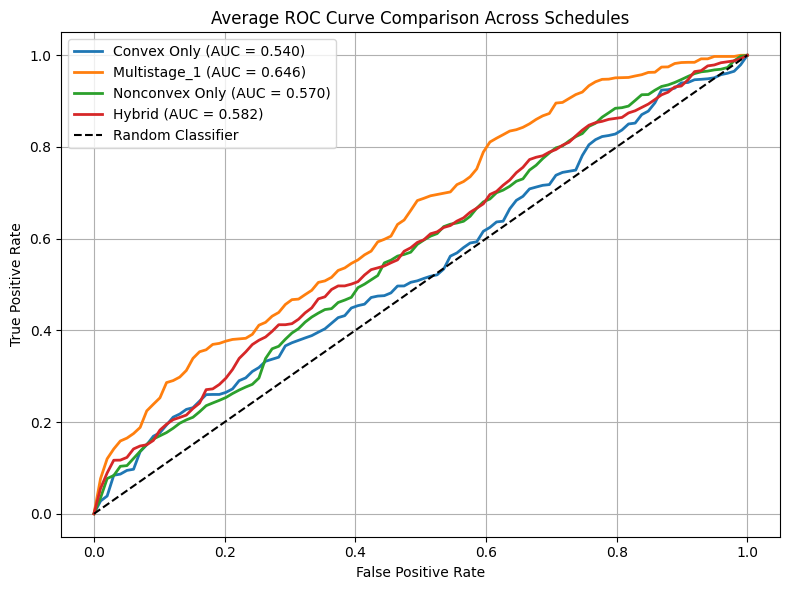

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
shap_feature_importance = {}


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.utils import class_weight




import tensorflow as tf
import tensorflow.keras.backend as K

class NoisyLossWrapper(tf.keras.losses.Loss):
    def __init__(self, base_loss_fn, noise_scale=0.5, name='noisy_loss'):
        super(NoisyLossWrapper, self).__init__(name=name)
        self.base_loss_fn = base_loss_fn
        self.noise_scale = noise_scale

    def call(self, y_true, y_pred):
        base_loss = self.base_loss_fn(y_true, y_pred)
        noise = tf.random.normal(shape=tf.shape(base_loss), mean=0.3, stddev=self.noise_scale) # make noise 0
        return base_loss + noise



def model_builder_convex():
    model = tf.keras.Sequential([
        
        # Handle padded sequences
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Convex-compatible LSTM (tanh + sigmoid only)
        tf.keras.layers.LSTM(
            32,
            activation='tanh',              # smooth, convex-friendly
            recurrent_activation='sigmoid', # safe gating
            return_sequences=False
        ),

        # Convex dense layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='softplus'),
                # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='softplus'),

        # Output (sigmoid for BCE)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


def model_builder():
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=(X_filtered.shape[1], X_filtered.shape[2])),
        tf.keras.layers.LSTM(128),
        #tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model




def model_builder_nonconvex():
    model = tf.keras.Sequential([
        # Handles padded sequences safely
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Non-convex temporal extractor
        tf.keras.layers.LSTM(
            32,
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=False,
           # kernel_initializer='glorot_uniform'
        ),

        # Deep non-convex block
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Output
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model







import tensorflow as tf

class ConvexFocalLoss(tf.keras.losses.Loss):
    """
    Convex-style Focal Loss using convex logistic link (softplus)
    instead of sigmoid. The focal term (1 - p_t)^gamma remains
    dynamic and fully inside the computational graph.
    """
    def __init__(self, gamma=0.5, alpha=0.25,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name='convex_focal_loss'):
        super().__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred_logits):

        # Softplus-based convex logistic components
        pos_term = tf.nn.softplus(-y_pred_logits)  # convex
        neg_term = tf.nn.softplus(y_pred_logits)   # convex

        # Convex surrogate "probability"
        # p = exp(-softplus(-z)) is convex in logits
        p = tf.exp(-pos_term)

        # Class-dependent p_t
        p_t = y_true * p + (1 - y_true) * (1 - p)

        # ---- Convex surrogate for focal weighting ----
        # Original: (1 - p_t)^gamma      → nonconvex
        # New convex surrogate: exp(-gamma * p_t)
        focal_weight = tf.exp(-self.gamma * p_t)   # convex & monotone decreasing

        # Base convex logistic loss
        base_loss = y_true * pos_term + (1 - y_true) * neg_term

        # Weighted convex loss (convex * convex → convex)
        loss = self.alpha * focal_weight * base_loss

        return tf.reduce_mean(loss)




convex_focal_loss_fn = ConvexFocalLoss(gamma=0.0, alpha=0.1)


#convex_focal_loss = NoisyLossWrapper(convex_focal_loss_fn, noise_scale=0.5)
convex_focal_loss=convex_focal_loss_fn
convex_focal_loss.__name__ = "convex_focal_loss"

nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.25, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#nonconvex_focal_loss = NoisyLossWrapper(nonconvex_focal_loss_fn, noise_scale=0.5)
nonconvex_focal_loss = nonconvex_focal_loss_fn
nonconvex_focal_loss.__name__ = "nonconvex_focal_loss"


hybrid_nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.5, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#hybrid_nonconvex_focal_loss = NoisyLossWrapper(hybrid_nonconvex_focal_loss_fn, noise_scale=0.5)
hybrid_nonconvex_focal_loss = hybrid_nonconvex_focal_loss_fn
hybrid_nonconvex_focal_loss.__name__ = "hybrid_nonconvex_focal_loss"



training_schedule_convex = [
    {"loss_fn": convex_focal_loss, "epochs": 100},
]

training_schedule_multistage_1 = [
    {"loss_fn": convex_focal_loss, "epochs": 10},
     {"loss_fn": nonconvex_focal_loss, "epochs":40},
      {"loss_fn": hybrid_nonconvex_focal_loss, "epochs":50},
]

training_schedule_multistage_2 = [
    {"loss_fn": convex_focal_loss, "epochs":10},
    {"loss_fn": nonconvex_focal_loss, "epochs":90},
]


hybrid_training_schedule_nonconvex = [
    {"loss_fn": hybrid_nonconvex_focal_loss, "epochs": 100},
]

training_schedule_nonconvex = [
    {"loss_fn": nonconvex_focal_loss, "epochs": 100},
]


def cross_validate(schedule, schedule_name, X_data, y_data, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    roc_data = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data)):
        print(f"\n📂 Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
        y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

        result = train_with_schedule_fold(schedule, schedule_name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold)
        metrics_list.append(result)
        roc_data.append((result["fpr"], result["tpr"]))

    avg_metrics = {
        "loss": np.mean([m["loss"] for m in metrics_list]),
        "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
        "precision": np.mean([m["precision"] for m in metrics_list]),
        "recall": np.mean([m["recall"] for m in metrics_list]),
        "f1": np.mean([m["f1"] for m in metrics_list]),
        "auc": np.mean([m["auc"] for m in metrics_list]),
    }

    print(f"\n📊 Average metrics for schedule '{schedule_name}': {avg_metrics}")
    return avg_metrics, roc_data


def get_model_type_from_loss(loss_fn):
    name = loss_fn.__name__.lower()

    if name.startswith("convex"):
        return "convex"
    elif name.startswith("nonconvex"):
        return "nonconvex"
    elif name.startswith("hybrid"):
        return "nonconvex"   # hybrid is nonconvex
    else:
        raise ValueError(f"Unknown loss type: {loss_fn.__name__}")




def train_with_schedule_fold(schedule, schedule_name, trainX, trainY, testX, testY, fold_index):
    first_loss = schedule[0]["loss_fn"]
    model_type = get_model_type_from_loss(first_loss)

    if model_type == "convex":
        model = model_builder_convex()
        #print(f"[FOLD {fold_index}] Using CONVEX model for loss: {first_loss.__name__}")

    else:
        model = model_builder_nonconvex()
        #print(f"[FOLD {fold_index}] Using NON-CONVEX model for loss: {first_loss.__name__}")

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    current_epoch = 0

    for i, stage in enumerate(schedule):
        loss_fn = stage["loss_fn"]
        epochs = stage["epochs"]
        print(f"\n➡️ Stage {i + 1} | Epochs: {epochs} | Loss: {loss_fn.__name__}")

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        model.fit(
            trainX, trainY,
            initial_epoch=current_epoch,
            epochs=current_epoch + epochs,
            batch_size=1,
            validation_data=(testX, testY),
            verbose=0
        )
        current_epoch += epochs

    eval_results = model.evaluate(testX, testY, verbose=0)
    y_pred_prob = model.predict(testX, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(testY, y_pred)
    auc_score = roc_auc_score(testY, y_pred_prob)
    fpr, tpr, _ = roc_curve(testY, y_pred_prob)

    # SHAP values for fold 1 only
    if fold_index == 0:
        print(f"🔍 Calculating SHAP values for fold 1 of '{schedule_name}'")
        background = trainX[:100].astype(np.float32)
        test_sample = testX[:100].astype(np.float32)

        # Recompile without metrics for SHAP
        model.compile(optimizer=optimizer, loss=loss_fn)

        explainer = shap.GradientExplainer(model, background)
        shap_values = explainer.shap_values(test_sample)[0]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = getattr(testX, "columns", [f"Feature {i}" for i in range(testX.shape[1])])
        shap_feature_importance[schedule_name] = dict(zip(feature_names, mean_abs_shap))

    return {
        "loss": eval_results[0],
        "accuracy": eval_results[1],
        "precision": eval_results[2],
        "recall": eval_results[3],
        "auc": auc_score,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr
    }

def average_roc_curves(roc_data, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    tprs = []

    for fpr, tpr in roc_data:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc

# 🧪 Run experiments and collect metrics
results_cv = {}
roc_data_schedules = {}


results_cv["Convex Only"], roc_data_schedules["Convex Only"] = cross_validate(training_schedule_convex, "Convex Only", X_resampled, y_resampled)
results_cv["Multistage_1"], roc_data_schedules["Multistage_1"] = cross_validate(training_schedule_multistage_1, "Multistage_1", X_resampled, y_resampled)
results_cv["Nonconvex Only"], roc_data_schedules["Nonconvex Only"] = cross_validate(training_schedule_nonconvex, "Nonconvex Only", X_resampled, y_resampled)
results_cv["Hybrid"], roc_data_schedules["Hybrid"] = cross_validate(hybrid_training_schedule_nonconvex, "Hybrid", X_resampled, y_resampled)
#results_cv["Multistage_2"], roc_data_schedules["Multistage_2"] = cross_validate(training_schedule_multistage_2, "Multistage_2", X_resampled, y_resampled)


# 📤 Export metrics to CSV
results_df = pd.DataFrame.from_dict(results_cv, orient='index')
results_df.to_csv("cross_validation_results_2.csv", index_label="Schedule")
print("✅ Metrics exported to 'cross_validation_results_2.csv'")

# 📊 Plot average ROC curves
plt.figure(figsize=(8, 6))
for name, data in roc_data_schedules.items():
    fpr, tpr, auc_val = average_roc_curves(data)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("Average ROC Curve Comparison Across Schedules")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
#shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

#shap_df = shap_df.sort_values("mean", ascending=True)
#shap_df.drop("mean", axis=1, inplace=True)


In [10]:
import numpy as np
import pandas as pd

# Suppose shap_feature_importance is a dict of lists or arrays
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)

# Flatten array entries
shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)

# Now compute row-wise mean
shap_df["mean"] = shap_df.mean(axis=1, numeric_only=True)

# Save
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")
shap_df.head()



/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_3517/4213904531.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)


,Convex Only,Multistage_1,Nonconvex Only,Hybrid,mean
Feature 0,1.137084e-14,6.058882e-08,9.464946e-10,7.933767e-08,3.521825e-08
Feature 1,2.434736e-11,8.817011e-03,1.339872e-05,1.312168e-05,2.210883e-03
Feature 2,1.061162e-18,7.320138e-09,6.983409e-12,9.944025e-10,2.080381e-09
Feature 3,4.989148e-13,2.325684e-05,1.139203e-08,8.372421e-07,6.026369e-06
Feature 4,1.093133e-12,6.146137e-03,1.787255e-04,2.226711e-05,1.586782e-03


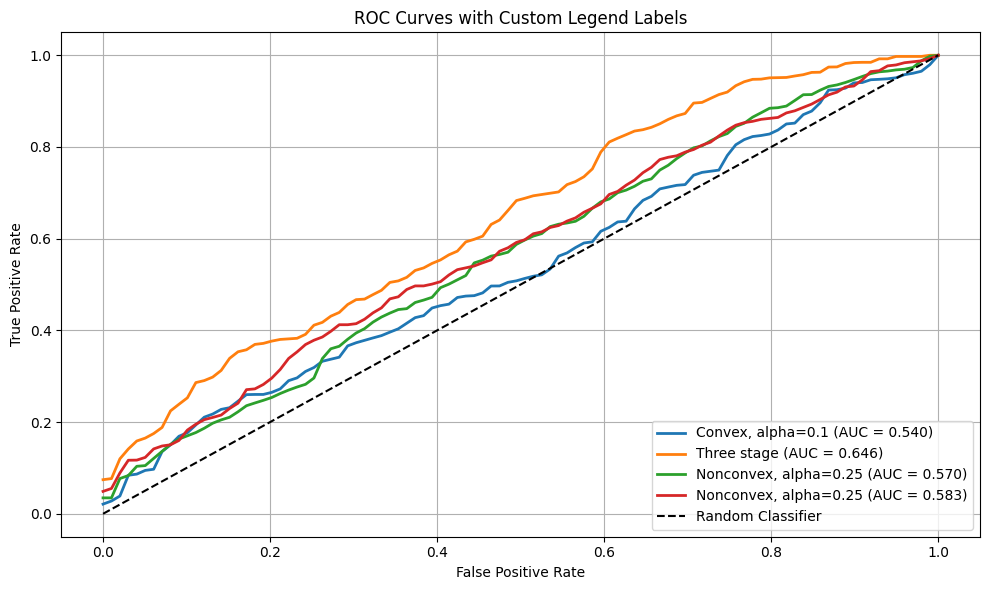

✅ Saved:
 - roc_custom_legend.png (ROC plot)
 - roc_summary_results.csv (AUC summary)
 - roc_curve_points.csv (All FPR–TPR points)


,Schedule,Label,AUC
0,Convex Only,"Convex, alpha=0.1",0.539802
1,Multistage_1,Three stage,0.645670
2,Nonconvex Only,"Nonconvex, alpha=0.25",0.569935
3,Hybrid,"Nonconvex, alpha=0.25",0.582688


,Schedule,FPR,TPR
0,Convex Only,0.000000,0.021118
1,Convex Only,0.010101,0.027890
2,Convex Only,0.020202,0.038788
3,Convex Only,0.030303,0.084028
4,Convex Only,0.040404,0.086549


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# === Function to compute average ROC curve ===
def average_roc_curves(roc_data_list):
    """
    roc_data_list: list of tuples [(fpr, tpr)] or [(fpr, tpr, auc_val)]
    Returns averaged fpr, tpr, and mean AUC
    """
    fpr_grid = np.linspace(0, 1, 100)
    tpr_interp = []
    auc_vals = []

    for entry in roc_data_list:
        # Handle 2-tuple or 3-tuple gracefully
        if len(entry) == 2:
            fpr, tpr = entry
        elif len(entry) == 3:
            fpr, tpr, _ = entry
        else:
            raise ValueError(f"Unexpected ROC entry shape: {entry}")
        tpr_interp.append(np.interp(fpr_grid, fpr, tpr))
        auc_vals.append(auc(fpr, tpr))

    mean_tpr = np.mean(tpr_interp, axis=0)
    mean_auc = np.mean(auc_vals)
    return fpr_grid, mean_tpr, mean_auc


# === Plot ROC curves ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
    "Nonconvex Only": "Nonconvex, alpha=0.25",
    "Hybrid": "Nonconvex, alpha=0.25",
   # "Multistage_2": "Two stage",
}

results = []
roc_points = []  # store all averaged ROC points

plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in roc_data_schedules:
        fpr, tpr, auc_val = average_roc_curves(roc_data_schedules[schedule])
        label = f"{legend_labels.get(schedule, schedule)} (AUC = {auc_val:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

        # Summary results
        results.append({
            "Schedule": schedule,
            "Label": legend_labels.get(schedule, schedule),
            "AUC": auc_val
        })

        # Store every (fpr, tpr) point
        for i in range(len(fpr)):
            roc_points.append({
                "Schedule": schedule,
                "FPR": fpr[i],
                "TPR": tpr[i]
            })
    else:
        print(f"⚠️ Warning: No ROC data for '{schedule}'")

# === Plot styling ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Custom Legend Labels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# === Save figure and data ===
plt.savefig("roc_custom_legend.png", dpi=300)
plt.show()

# Save AUC summary
roc_summary = pd.DataFrame(results)
roc_summary.to_csv("roc_summary_results.csv", index=False)

# Save all ROC points
roc_points_df = pd.DataFrame(roc_points)
roc_points_df.to_csv("roc_curve_points.csv", index=False)

print("✅ Saved:")
print(" - roc_custom_legend.png (ROC plot)")
print(" - roc_summary_results.csv (AUC summary)")
print(" - roc_curve_points.csv (All FPR–TPR points)")
display(roc_summary.head())
display(roc_points_df.head())


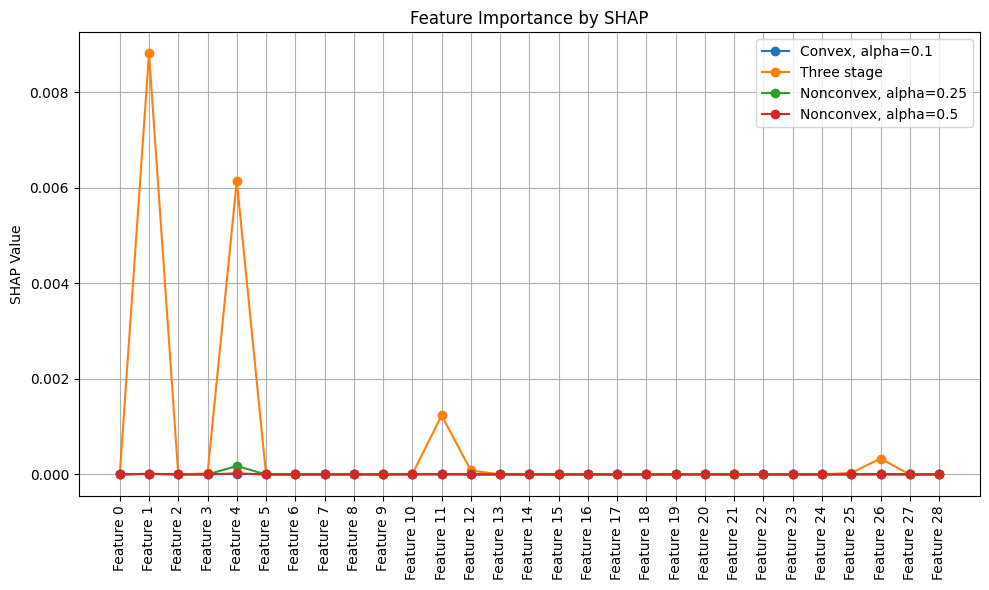

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === Load and preprocess the SHAP file ===
shap_df = pd.read_csv("cross_validation_shap_2.csv")
shap_df.columns = shap_df.columns.str.strip()

# Convert SHAP value strings to floats
for col in shap_df.columns[1:]:
    shap_df[col] = shap_df[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

# === Step 1: Define original and custom legend names ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
    "Nonconvex Only": "Nonconvex, alpha=0.25",
    "Hybrid": "Nonconvex, alpha=0.5",
    #"Multistage_2": "Two stage",
}

# === Step 2: Plot each schedule with a custom label ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in shap_df.columns:
        plt.plot(shap_df["Schedule"], shap_df[schedule], marker='o', label=legend_labels.get(schedule, schedule))
    else:
        print(f"Warning: Schedule '{schedule}' not found.")

plt.xticks(rotation=90)
plt.ylabel("SHAP Value")
plt.title("Feature Importance by SHAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("shap_plot_custom_legend.png")
plt.show()
